OECD API with Python
======

## Guide to the SDMX REST API

-----

*February 2026*<br>
*@bd_econ*

The Organization for Economic Cooperation and Development (OECD) provides data through an SDMX REST API. Documentation is [here](https://data.oecd.org/api/).

This notebook demonstrates how to find and retrieve OECD data using Python's `requests` library with CSV output.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import io

## How to Find Data

Use the [OECD Data Explorer](https://data-explorer.oecd.org/) to browse available datasets:

1. Search for the series you are interested in (e.g., "GDP per hour worked")
2. Filter by country, time period, or other dimensions
3. Click **Developer API** to get the SDMX query URL

The Data Explorer generates a ready-to-use URL that you can paste directly into your code.

## Understanding the URL Structure

OECD SDMX REST URLs follow this pattern:

```
https://sdmx.oecd.org/public/rest/data/{agency,dataflow,version}/{dimensions}?{params}
```

**Components:**
- **agency,dataflow,version** — Identifies the dataset (e.g., `OECD.SDD.TPS,DSD_PDB@DF_PDB_LV,1.0`)
- **dimensions** — Dot-separated filter values. Use `+` for multiple values in one dimension (e.g., `DNK+FIN+USA`). Leave a dimension empty (two consecutive dots) to get all values.
- **params** — Query parameters like `startPeriod`, `endPeriod`, and `format`

Setting `format=csvfilewithlabels` returns a CSV with human-readable column names, which is convenient for loading into pandas.

## Example 1: GDP per Hour Worked

A cross-country comparison of labor productivity, measured as GDP per hour worked in USD PPP. The dataflow `DF_PDB_LV` is the OECD productivity database. The dimensions filter for five countries, annual frequency, and GDP per hour worked in USD PPP.

In [2]:
# URL obtained from OECD Data Explorer
url = ('https://sdmx.oecd.org/public/rest/data/'
       'OECD.SDD.TPS,DSD_PDB@DF_PDB_LV,1.0/'
       'DNK+FIN+NOR+SWE+USA.A.GDPHRS..USD_PPP_H.Q...?'
       'startPeriod=2000&format=csvfilewithlabels')

r = requests.get(url)
print(f'Status: {r.status_code}')

Status: 200


### Explore the Response

The CSV has many columns, but the key ones are `REF_AREA` (country code), `TIME_PERIOD`, and `OBS_VALUE`. We can pivot the data so each country becomes a column.

In [3]:
res = pd.read_csv(io.StringIO(r.text))
print('Columns:', list(res.columns))
res[['REF_AREA', 'Reference area', 'TIME_PERIOD', 'OBS_VALUE']].tail()

Columns: ['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA', 'Reference area', 'FREQ', 'Frequency of observation', 'MEASURE', 'Measure', 'ACTIVITY', 'Economic activity', 'UNIT_MEASURE', 'Unit of measure', 'PRICE_BASE', 'Price base', 'TRANSFORMATION', 'Transformation', 'ADJUSTMENT', 'Adjustment', 'CONVERSION_TYPE', 'Conversion type', 'TIME_PERIOD', 'Time period', 'OBS_VALUE', 'Observation value', 'OBS_STATUS', 'Observation status', 'UNIT_MULT', 'Unit multiplier', 'BASE_PER', 'Base period', 'DECIMALS', 'Decimals']


,REF_AREA,Reference area,TIME_PERIOD,OBS_VALUE
119,DNK,Denmark,2002,73.417047
120,DNK,Denmark,2001,72.825868
121,DNK,Denmark,2000,72.990714
122,NOR,Norway,2003,88.626662
123,SWE,Sweden,2024,81.847507


### Clean and Visualize

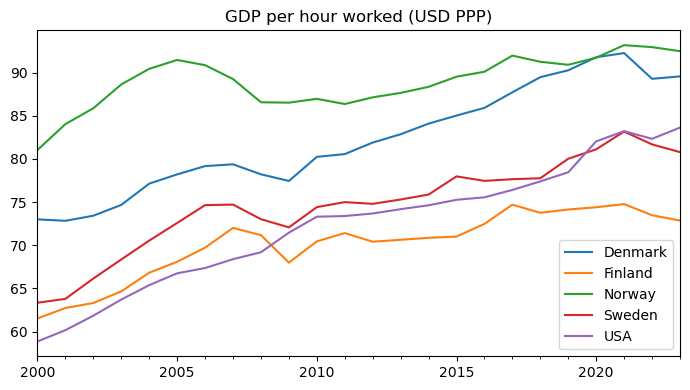

In [4]:
data = res.set_index(['REF_AREA', 'TIME_PERIOD'])['OBS_VALUE'].unstack().T
data.index = pd.to_datetime(data.index, format='%Y')
data.index.name = ''
data.columns.name = ''

rn = {'DNK': 'Denmark', 'FIN': 'Finland', 'NOR': 'Norway',
      'SWE': 'Sweden', 'USA': 'USA'}

data.rename(columns=rn).dropna().plot(
    title='GDP per hour worked (USD PPP)', figsize=(7, 4))
plt.tight_layout()
plt.show()

## Example 2: Health Spending vs. Life Expectancy

This example combines two OECD datasets to create a scatter plot:
- **Health spending** as a share of GDP, from the System of Health Accounts (`DF_SHA`)
- **Life expectancy** at birth, from health statistics (`DF_LE`)

Both datasets have many dimensions. The key is filtering to the right combination of totals. The health spending URL filters for total expenditure (`EXP_HEALTH`), as a share of GDP (`PT_B1GQ`), all financing schemes (`_T`), all functions (`_T`), and all providers (`_T`). The life expectancy URL filters for life expectancy at birth (`LFEXP`, age `Y0`), both sexes (`_T`).

In [5]:
# Health spending as % of GDP (System of Health Accounts)
url_health = ('https://sdmx.oecd.org/public/rest/data/'
              'OECD.ELS.HD,DSD_SHA@DF_SHA,1.0/'
              '.A.EXP_HEALTH.PT_B1GQ._T._Z._T._T._T._Z._Z._Z'
              '?startPeriod=2022&format=csvfilewithlabels')

# Life expectancy at birth, both sexes
url_life = ('https://sdmx.oecd.org/public/rest/data/'
            'OECD.ELS.HD,DSD_HEALTH_STAT@DF_LE,1.1/'
            '.A.LFEXP..Y0._T._Z._Z._Z._Z._Z._Z._Z'
            '?startPeriod=2022&format=csvfilewithlabels')

r1 = requests.get(url_health)
r2 = requests.get(url_life)
print(f'Health spending: {r1.status_code}, Life expectancy: {r2.status_code}')

Health spending: 200, Life expectancy: 200


In [6]:
# Parse and take most recent value per country
df1 = pd.read_csv(io.StringIO(r1.text))
health = (df1.set_index(['REF_AREA', 'TIME_PERIOD'])['OBS_VALUE']
          .unstack().T.ffill().iloc[-1].dropna())

df2 = pd.read_csv(io.StringIO(r2.text))
life = (df2.set_index(['REF_AREA', 'TIME_PERIOD'])['OBS_VALUE']
        .unstack().T.ffill().iloc[-1].dropna())

# Merge on country code
scatter = pd.DataFrame({'Health spending (% of GDP)': health,
                        'Life expectancy (years)': life}).dropna()
print(f'{len(scatter)} countries')
scatter.sort_values('Health spending (% of GDP)').tail(10)

49 countries


,Health spending (% of GDP),Life expectancy (years)
REF_AREA,,
JPN,10.625,84.1
BEL,10.969,82.5
GBR,11.133,81.0
CAN,11.298,81.7
SWE,11.312,83.4
FRA,11.541,83.0
CHE,11.773,84.3
AUT,11.777,81.9
DEU,12.267,81.1


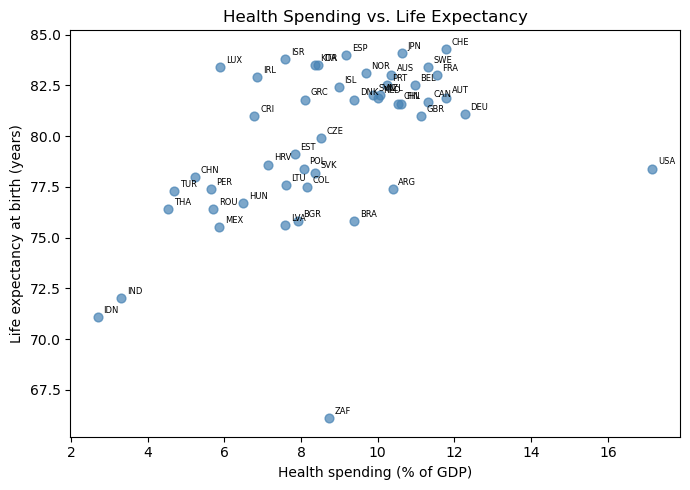

In [7]:
x = scatter['Health spending (% of GDP)']
y = scatter['Life expectancy (years)']

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, s=40, alpha=0.7, color='steelblue')

for country in scatter.index:
    ax.annotate(country, (x[country], y[country]),
                fontsize=6, xytext=(4, 3),
                textcoords='offset points')

ax.set_xlabel('Health spending (% of GDP)')
ax.set_ylabel('Life expectancy at birth (years)')
ax.set_title('Health Spending vs. Life Expectancy')
plt.tight_layout()
plt.show()